Jumlah label: Label
1    4478
0    2402
Name: count, dtype: int64


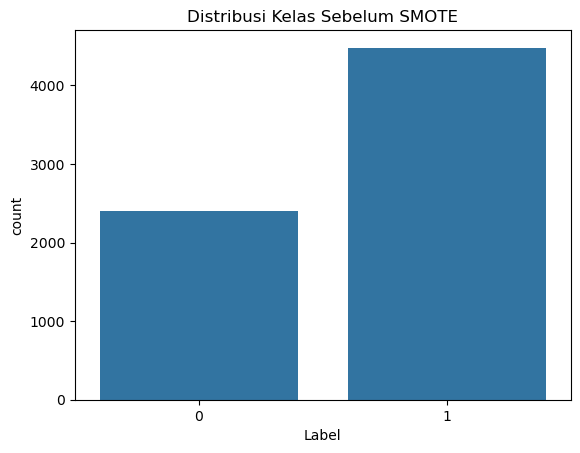

In [ ]:
# ========== INSTALL REQUIREMENTS (jalankan di Anaconda Prompt jika belum) ==========
# pip install scikit-learn imbalanced-learn matplotlib seaborn pandas openpyxl Sastrawi joblib

# ========== IMPORT LIBRARY ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import joblib

# ========== FUNGSI CLEANING TEKS ==========
stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()
stemmer = StemmerFactory().create_stemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords]
    text = " ".join(tokens)
    text = stemmer.stem(text)
    return text

# ========== LOAD DATA ==========
df = pd.read_excel("Dataset Hoax.xlsx")
print("Jumlah label:", df['Label'].value_counts())

# ========== VISUALISASI SEBELUM SMOTE ==========
sns.countplot(x='Label', data=df)
plt.title("Distribusi Kelas Sebelum SMOTE")
plt.show()

# ========== CLEANING ==========
df['CleanText'] = df['Text'].apply(clean_text)
X = df['CleanText']
y = df['Label']

# ========== TF-IDF ==========
vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = vectorizer.fit_transform(X)

# ========== SMOTE ==========
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Visualisasi setelah SMOTE
sns.countplot(x=y_resampled)
plt.title("Distribusi Kelas Setelah SMOTE")
plt.show()

# ========== SPLIT DATA ==========
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# ========== TRAINING LOGISTIC REGRESSION ==========
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# ========== EVALUASI ==========
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# ========== SAVE MODEL DAN VECTORIZER ==========
joblib.dump(model, "logreg_hoax_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("Model dan vectorizer berhasil disimpan.")
